In [13]:
import pandas as pd
import numpy as np
import plotly.express as px
from pathlib import Path
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN


In [14]:
DATA_ROOT = Path("data")
PROCESSED_DATA = DATA_ROOT / "processed"

trends = pd.read_csv(PROCESSED_DATA / "trends.csv", index_col=0, parse_dates=True)
prices = pd.read_csv(PROCESSED_DATA / "prices.csv", index_col=0, parse_dates=True)
volumes = pd.read_csv(PROCESSED_DATA / "volumes.csv", index_col=0, parse_dates=True)

trends.shape, prices.shape, volumes.shape

((1783, 1859), (1783, 92), (1783, 92))

In [15]:
def normalize_df(df: pd.DataFrame) -> pd.DataFrame:
    # return (df - df.min()) / (df.max() - df.min())
    return df/df.sum(axis=0)

trends = normalize_df(trends)
prices = normalize_df(prices)
volumes = normalize_df(volumes)

unified = pd.concat([trends, volumes], axis=1).T
unified.shape

(1951, 1783)

In [16]:
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=0)
X_embedded = reducer.fit_transform(unified)


ts_kmeans = TimeSeriesKMeans(n_clusters=5, metric="euclidean", random_state=0)
labels = ts_kmeans.fit_predict(unified)
count = np.unique(labels, return_counts=True)
pd.Series(count[1], index=count[0]).sort_index()

ValueError: Input contains NaN.

In [25]:
unified[labels == 0].index[-2]

'Apple Vision Pro vs competitor'

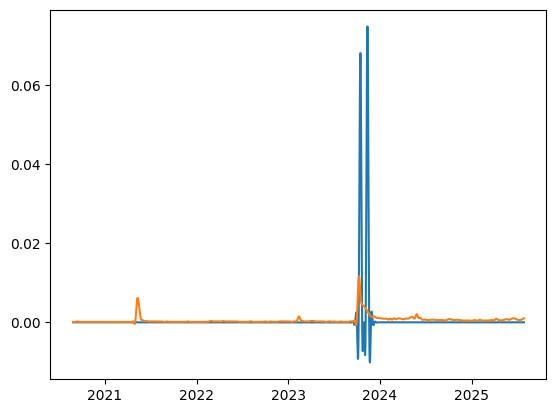

In [29]:
import matplotlib.pyplot as plt
plt.plot(unified.loc['Apple Vision Pro vs competitor'], label='Apple')

plt.plot(unified.loc['Palestine'], label='Palestine')

In [18]:
fig = px.scatter(
    x=X_embedded[:, 0],
    y=X_embedded[:, 1],
    color=labels.astype(str),
    hover_name=[f"{col}" for col in unified.index],
    title="Soft-DTW Time Series Clustering (UMAP visualization)",
    width=1200,
    height=1200
)
fig.update_traces(marker=dict(size=10, line=dict(width=1, color='DarkSlateGrey')))
fig.show()